In [ ]:
# laplace-CAN-paper-figures.ipynb
#
# Bryan Daniels
# 2024/2/7 branched from develop-exponential-decay-transition.ipynb
# 2024/1/25
#

Simulating a continuous attractor network (CAN) that matches with the Laplace
transform picture of Howard et al. 2018.  We have:

   - Units connected in a 1-D topology with marginally stable activity patterns
     that consist of an "edge" at any location along the line
   - The edge moves with speed that scales as $1/t$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

from laplace_network import laplace_network,find_edge_location,interaction_matrix_from_kernel

In [2]:
def edge_Jmat_with_shift(edge_shift,t_0,n_0,Npopulation,J):
    kernel = [desiredBumpRates(Npopulation-10-n,t_0,n_0=(Npopulation-10)/2-edge_shift) for n in range(Npopulation-10+1)]
    return J*interaction_matrix_from_kernel(kernel,Npopulation)

In [3]:
def edge_one_step_velocity(edge_Jmat,sigma_edge,t_0,n_0,Npopulation,J,delta_z,nonlinearity):
    """
    Change in position of the edge after going once through the synaptic nonlinearity and given interaction matrix.
    """
    edge_state = J*(2*desiredEdgeRates(np.arange(0,Npopulation),t_0,delta_z=delta_z,n_0=n_0)-1)
    edge_synaptic_out = nonlinearity(edge_state/sigma_edge)
    corresponding_steady_state = np.dot(edge_Jmat,edge_synaptic_out)
    steady_state_n_bar = np.sort(abs(find_edge_location(corresponding_steady_state)))[0]
    return steady_state_n_bar - n_0

In [4]:
def find_zero_velocity_edge_shift(sigma_edge,t_0,n_0,Npopulation,J,delta_z,nonlinearity):
    """
    Find interaction matrix edge shift that gives zero velocity under the dynamics with given sigma_edge.

    Note: sigma_edge = 0 should correspond to zero velocity with edge shift = 0. 
    """
    vel_sq = lambda edge_shift: edge_one_step_velocity(edge_Jmat_with_shift(edge_shift,t_0,n_0,Npopulation,J),
                                                       sigma_edge,t_0,n_0,Npopulation,J,delta_z,nonlinearity)**2
    result = scipy.optimize.minimize_scalar(vel_sq) #,bracket=(-1,0,1))
    assert(result['fun'] < 1e-10) # make sure we were successful
    return result['x']

In [5]:
def zero_velocity_edge_Jmat(sigma_edge,t_0,n_0,Npopulation,J,delta_z,nonlinearity):
    """
    Return edge_Jmat interaction matrix that gives zero velocity under the dynamics with given sigma_edge.
    """
    edge_shift = find_zero_velocity_edge_shift(sigma_edge,t_0,n_0,Npopulation,J,delta_z,nonlinearity)
    return edge_Jmat_with_shift(edge_shift,t_0,n_0,Npopulation,J)

In [6]:
def nice_neuron_xlabels(Npopulation):
    labels=['' for i in range(Npopulation)]
    labeled_n = [0,int(Npopulation/2),Npopulation-1]
    for n in labeled_n:
        labels[n] = n
    plt.xticks(ticks=range(Npopulation),labels=labels)
    defaultFigure.makePretty()

In [25]:
def translation_simulation_plot(net,states,pre_nonlinearity_states,n_0,t_0,state_min=-2.5,state_max=2.5,input_min=-0.5,input_max=0.1):
    plt.figure(figsize=(6,9))
    minInput,maxInput = 0,4
    minNeuron,maxNeuron = n_0-30, n_0+30
    times = [t_0,t_0*2,t_0*4]
    
    # firing rate plot, edge neurons
    plt.subplot(4,1,1)
    for t in times:
        plt.plot(states.loc[t]['Neuron 0':'Neuron {}'.format(net.Npopulation-1)],
                 '.-',label="t = {}".format(int(t)),lw=1,ms=3)
    #plt.hlines(0,0,50,color='k',lw=0.5)
    #plt.xlabel('Neural unit')
    plt.ylabel('State,\nedge neurons')
    nice_neuron_xlabels(net.Npopulation)
    leg = plt.legend(framealpha=1)
    defaultFigure.makePretty(leg=leg)
    plt.axis(xmin=minNeuron,xmax=maxNeuron,ymin=state_min,ymax=state_max)
    
    # firing rate plot, bump neurons
    plt.subplot(4,1,2)
    for t in times:
        plt.plot(states.loc[t]['Neuron {}'.format(net.Npopulation):'Neuron {}'.format(2*net.Npopulation-1)],
                 '.-',label="t = {}".format(t),lw=1,ms=3)
    #plt.hlines(0,0,50,color='k',lw=0.5)   
    #plt.xlabel('Neural unit')
    plt.ylabel('State,\nbump neurons')
    nice_neuron_xlabels(net.Npopulation)
    #leg = plt.legend(framealpha=1)
    defaultFigure.makePretty()
    plt.axis(xmin=minNeuron,xmax=maxNeuron,ymin=state_min,ymax=state_max)
    
    # interaction strength from bump to edge neurons
    plt.subplot(4,1,3)
    plt.plot(-np.array(J_bump_edge))
    plt.ylabel('synaptic strength\nbump -> edge')
    #plt.xlabel('Neural unit')
    plt.yscale('log')
    nice_neuron_xlabels(net.Npopulation)
    plt.axis(xmin=minNeuron,xmax=maxNeuron,)
    
    # input from bump neurons to edge neurons
    plt.subplot(4,1,4)
    for t in times:
        if np.shape(net.sigma) == (net.Ntotal,net.Ntotal):
            activities_t = np.tanh(np.tile(pre_nonlinearity_states.loc[t],(net.Ntotal,1))/net.sigma) # (NtotalxNtotal)
            bump_to_edge_activities = activities_t[:net.Npopulation,net.Npopulation:2*net.Npopulation] # (NpopulationxNpopulation)
            bump_to_edge_input = np.sum(net.bump_edge_Jmat*np.array(bump_to_edge_activities),axis=1) # (N)
            bump_to_edge_input = pd.Series(bump_to_edge_input,index=pre_nonlinearity_states.columns[:net.Npopulation])
        else:
            activities = np.tanh(pre_nonlinearity_states/net.sigma)
            
            bumpActivities = activities.loc[t]['Neuron {}'.format(net.Npopulation):'Neuron {}'.format(2*net.Npopulation-1)]
            bump_to_edge_input = np.dot(bumpActivities,net.bump_edge_Jmat)
        plt.plot(bump_to_edge_input,'.-',label="t = {}".format(t),lw=1,ms=3)
    #plt.hlines(0,0,50,color='k',lw=0.5)   
    plt.xlabel('Neural unit')
    plt.ylabel('Input from bump\nto edge neurons')
    nice_neuron_xlabels(net.Npopulation)
    plt.axis(xmin=minNeuron,xmax=maxNeuron,ymin=input_min,ymax=input_max)
    
    plt.subplots_adjust(bottom=0.1,top=0.95,left=0.2,right=0.95)    

In [8]:
def edge_location_plot(net,states,n_0,t_0,skip=10):
    # plot edge location versus time
    plt.plot(states.index[::skip],[np.sort(abs(find_edge_location(states.loc[i])))[0] for i in states.index[::skip]],'.',label='Simulation')
    plt.plot(states.index,n_0+1./delta_z*np.log(states.index/t_0),
             label='$n_0+ (\Delta z)^{-1}\log(t/t_0)$',lw=2)
    plt.xlabel('Time $t$')
    plt.ylabel('Edge location (neuron number)')
    leg = plt.legend()
    defaultFigure.makePretty(leg=leg)
    #plt.savefig('231117_self_sustained_edge_location_vs_time.pdf')
    plt.axis(ymin=n_0-2)
    plt.xscale('log')

In [9]:
def time_rescaling_plot(states,n_0,t_0,t_max=80,t_max_rescaled=8,state_min=-2.5,state_max=+2.5):
    plt.figure(figsize=(10,3))
    
    # plot state over time for particular neurons
    plt.subplot(1,2,1)
    neuron_indices = range(n_0,n_0+10)
    
    for neuron_index in neuron_indices:
        name = 'Neuron {}'.format(neuron_index)
        plt.plot(states[name],label=name,
                 color='C{}'.format(neuron_index-n_0)) #color=str((neuron_index-n_0)/10))
    leg = plt.legend(loc=(2.4,-0.03))
    plt.xlabel('Time')
    plt.ylabel('Neural state')
    plt.axis(ymin=state_min,ymax=state_max)
    plt.subplots_adjust(left=0.15,right=0.95)
    defaultFigure.makePretty(leg=leg)
    #plt.savefig('231018_firing_rate_vs_time.pdf')
    
    # plot rate over time for particular neurons, rescaled in time
    plt.subplot(1,2,2)
    neuron_indices = range(n_0,n_0+10)
    for neuron_index in neuron_indices:
        name = 'Neuron {}'.format(neuron_index)
        times = states[name].index
        tau = t_0*np.exp((neuron_index-n_0)*delta_z)
        plt.plot(times/tau,states[name],label=name,
                 color='C{}'.format(neuron_index-n_0)) #str((neuron_index-n_0)/10))
    
    #leg = plt.legend()
    plt.xlabel('Time/$\\tau_i$')
    plt.ylabel('Neural state')
    plt.axis(ymin=state_min,ymax=state_max,xmin=0,xmax=t_max_rescaled)
    plt.subplots_adjust(left=0.15,right=0.95)
    defaultFigure.makePretty(leg=leg)
    #plt.yscale('log')
    
    plt.subplots_adjust(wspace=0.3,bottom=0.2,top=0.95,left=0.1,right=0.825)
    

# Demonstrate exponential decay using asymmetric interaction kernel

In [10]:
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
delta_z = 1./4. #1./8. #1./4 #1./4. #0.5 #1 
n_0_asymmetric = 50 #15 #15 # 25 (25 used for 231117 plots)
t_0_asymmetric = 10. #5 #1. #10. #10. #1. (1. used for 231117 plots) #0.1 #0.5

# define the shapes of edges and bumps we want in order to get exponential decay

def desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0_asymmetric,t_0=t_0_asymmetric):
    return np.exp( -(t/t_0)*np.exp(-delta_z*(n-n_0)+np.log(np.log(2))) )

# 2024/2/2 TO DO: Should this have another factor of t_0 somewhere?
def desiredBumpRates(n,t,delta_z=delta_z,n_0=n_0_asymmetric):
    return t*desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0)*delta_z/np.exp(delta_z*(n-n_0))

In [11]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 100 #50 # number of units in each population
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n 
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor = 0.65 # 0.65 fit by eye for sigma_edge=0.5 
J_bump_edge = [ -J_bump_edge_scale_factor*min(1./t_0_asymmetric*1./delta_z*np.exp(-delta_z*(n-n_0_asymmetric)),
                                              J_bump_edge_max) for n in range(Npopulation) ]
nonlinearity = np.tanh 
# 2024/1/26 set sigma to 1 for all synapses except edge->edge
sigma_edge = 0.25 #0.25 #0.5 #0.25 #0.75 #0.25 #0.5
sigma_default = np.ones([Npopulation,Npopulation])
sigma = np.block([[sigma_edge*sigma_default, sigma_default],
                  [           sigma_default, sigma_default]])

net_asymmetric = laplace_network(Npopulation,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      #kernel_width=kernel_width,
                      nonlinearity=nonlinearity,
                      sigma=sigma)

# 2024/1/23 try replacing edge interaction kernel to give the desired steady state given the 
# step-function nonlinearity
# 2024/2/6 also add a shift to fix the bias coming from nonzero sigma

net_asymmetric.edge_Jmat = zero_velocity_edge_Jmat(sigma_edge,
                                                   t_0_asymmetric,
                                                   n_0_asymmetric,
                                                   net_asymmetric.Npopulation,
                                                   net_asymmetric.J,
                                                   delta_z,
                                                   net_asymmetric.nonlinearity)

net_asymmetric.Jmat = np.block(
    [[net_asymmetric.edge_Jmat, net_asymmetric.bump_edge_Jmat],
     [net_asymmetric.edge_bump_Jmat, net_asymmetric.bump_Jmat]])
net_asymmetric.Jmat_no_feedback = np.block(
    [[net_asymmetric.edge_Jmat, np.zeros((net_asymmetric.Npopulation,net_asymmetric.Npopulation))],
     [net_asymmetric.edge_bump_Jmat, net_asymmetric.bump_Jmat]])

In [12]:
# run simulation

# noise_var = 1e-6 (1e-6 used for more recent plots) #1e-4 (1e-4 used for 231117 plots) # 0.1
noise_var = 1e-6 #0. # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0_asymmetric + 2**(i_final-1)
delta_t = 0.01 #0.001 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_t = t_0_asymmetric 
initial_guess_edge = net_asymmetric.J*(2*desiredEdgeRates(np.arange(0,Npopulation),edge_t,delta_z=delta_z,n_0=n_0_asymmetric)-1)
edge_state = net_asymmetric.find_edge_state(n_0_asymmetric,
                                 initial_guess_edge=initial_guess_edge,
                                 method='translate')

# simulate dynamics
states_asymmetric = net_asymmetric.simulate_dynamics(edge_state,
                               t_final-t_0_asymmetric,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_asymmetric.index = states_asymmetric.index + t_0_asymmetric

Text(0, 0.5, 'Neural state')

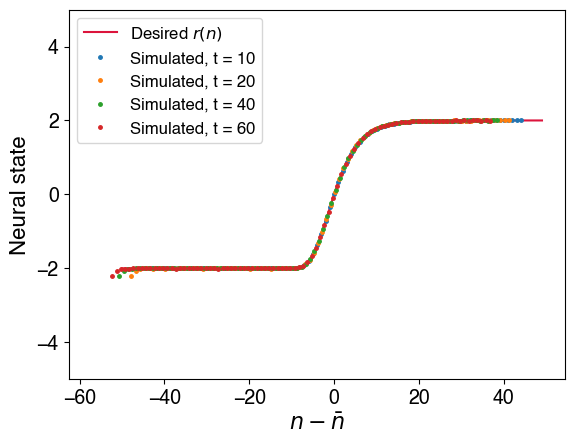

In [13]:
# compare simulated shape of edge to desired shape

nList = np.arange(0,net_asymmetric.Npopulation)
t = 20 #1 #20
desired_edge_shape = net_asymmetric.J*(2*desiredEdgeRates(nList,edge_t,delta_z=delta_z,n_0=n_0_asymmetric)-1)
desired_edge_offset = find_edge_location(desired_edge_shape)[0]
plt.plot(nList-desired_edge_offset,desired_edge_shape,
         label='Desired $r(n)$',
         color='crimson')

for t in [t_0_asymmetric,
          t_0_asymmetric*2,
          t_0_asymmetric*4,
          t_0_asymmetric*6]:
    edge_offset = np.sort(abs(find_edge_location(states_asymmetric.loc[t])))[0]
    plt.plot(nList - edge_offset,
             states_asymmetric.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
                 '.',label="Simulated, t = {}".format(int(t)),lw=1,ms=5)
plt.axis(ymin=-5,ymax=+5)
plt.legend()
plt.xlabel('$n - \\bar n$')
plt.ylabel('Neural state')

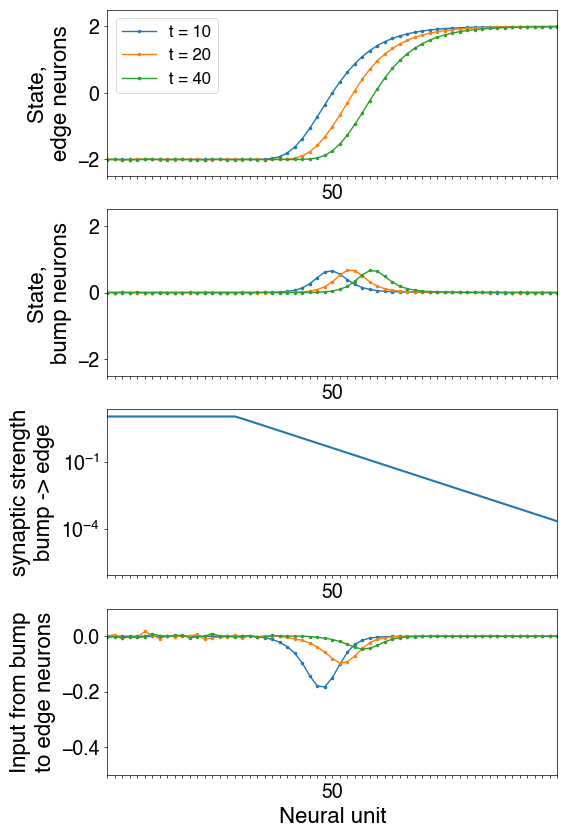

In [26]:
translation_simulation_plot(net_asymmetric,states_asymmetric,states_asymmetric,n_0_asymmetric,t_0_asymmetric)
#plt.savefig('231117_self_sustained_edge_decaying_velocity.pdf')

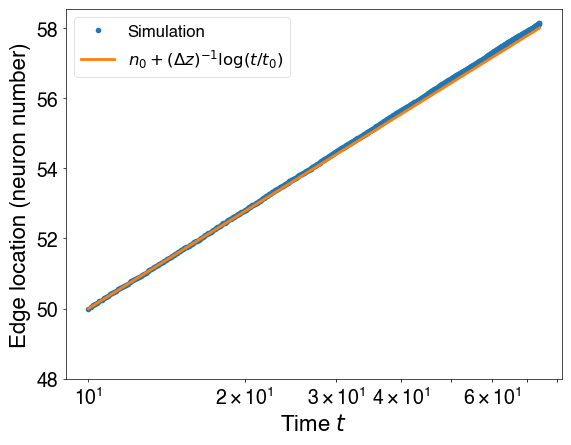

In [15]:
edge_location_plot(net_asymmetric,states_asymmetric,n_0_asymmetric,t_0_asymmetric)

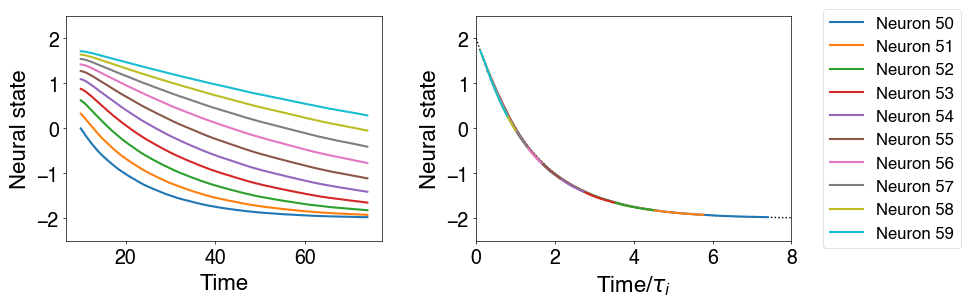

In [16]:
t_max = 80

time_rescaling_plot(states_asymmetric,n_0_asymmetric,t_0_asymmetric,t_max=t_max)

# also plot analytical result as dotted line
analytical_times = np.linspace(0,t_max,1000)
plt.plot(analytical_times/t_0_asymmetric,
         net_asymmetric.J*(2*desiredEdgeRates(n_0_asymmetric,analytical_times,n_0=n_0_asymmetric)-1),
         'k:',
         zorder=-10,
         lw=1,)
#plt.savefig('240118_firing_rate_vs_time.pdf')

# Demonstrate geometric series of timescales using symmetric kernel

In [17]:
def states2rates(states):
    return 0.5*(1.+np.tanh(states))

In [18]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation_symmetric = 100 #50 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
delta_z = 1./4. #0.5 #1 
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0_symmetric = 10. 
n_0_symmetric = 50  
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor = 1 #2 #0.1 #0.5 #0.9 (0.9 used for 231117 plots)
J_bump_edge = [ -J_bump_edge_scale_factor*min(1./t_0_symmetric*1./delta_z*np.exp(-delta_z*(n-n_0_symmetric)),
                                              J_bump_edge_max) for n in range(Npopulation_symmetric) ]
kernel_width = 2 
nonlinearity = np.tanh 
sigma = 1. 

net_symmetric = laplace_network(Npopulation_symmetric,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width,
                      nonlinearity=nonlinearity,
                      sigma=sigma)

In [19]:
# run simulation

noise_var = 1e-6 #1e-4 (1e-4 used for 231117 plots) # 0.1 # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0_symmetric + 2**(i_final-1)
delta_t = 0.01 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_state = net_symmetric.find_edge_state(n_0_symmetric)
    
# simulate dynamics
states_symmetric = net_symmetric.simulate_dynamics(edge_state,
                               t_final-t_0_symmetric,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_symmetric.index = states_symmetric.index + t_0_symmetric
rates_symmetric = states2rates(states_symmetric)

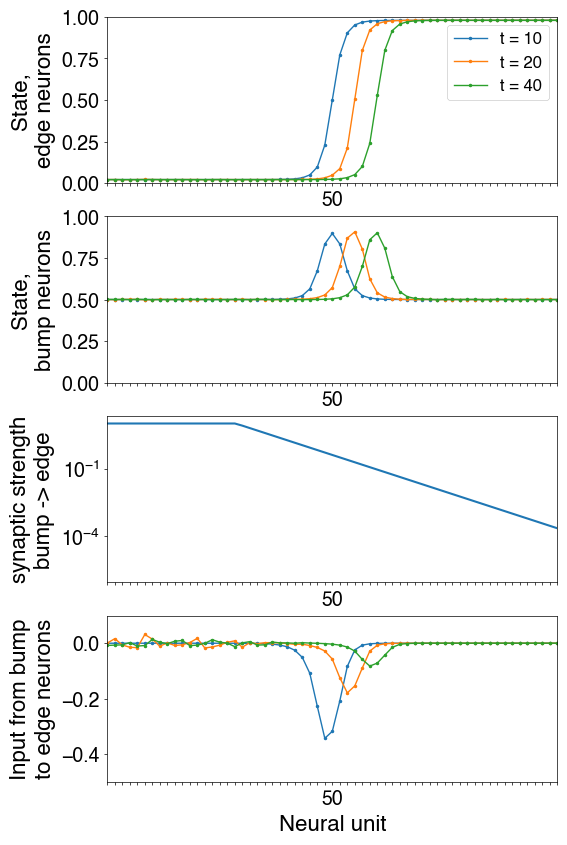

In [27]:
translation_simulation_plot(net_symmetric,rates_symmetric,states_symmetric,
                            n_0_symmetric,t_0_symmetric,
                            state_min=0,state_max=1)

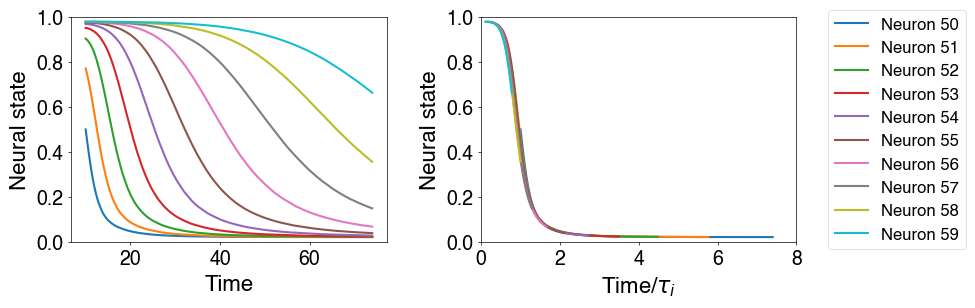

In [38]:
time_rescaling_plot(rates_symmetric,n_0_symmetric,t_0_symmetric,
                   state_min=0,state_max=1)